# HOW ARE CELLS CONNECTED

In this notebook we will answer the following question : how are cells connected ? First we will count the number of non triangular junctions between cells per image and create a csv with their coordinates. Then we will create another csv resuming the number of non triangular junctions between cells and the total number of junctions per image but also the name of the first csv corresponding to the image. Finalement we will sum up our finding on a bar plot

In [1]:
# We import the useful functions from the script save in the src folder

from src.utils_connection import *

# We import some existent libraries 

import pandas as pd
from tifffile import imread
import napari
from skimage import restoration
import skimage.filters as filters
from skimage.morphology import disk
from skimage import morphology
from skimage.feature import peak_local_max
from skimage.morphology import convex_hull_image
from skimage.segmentation import watershed
from scipy import ndimage as ndi
import numpy as np
import pandas as pd
from skimage import measure
import matplotlib.pyplot as plt
import tifffile
from scipy import ndimage as ndi
import skimage
from skimage.color import rgb2gray
from typing import List
from magicgui import magicgui
from napari.types import ImageData, LabelsData, LayerDataTuple
import numpy as np
import glob
from skimage import feature

# ALL USER CHOICE

In [2]:
data_folder_path = "/home/criuser/Bureau/Informatique/Projet"  # adapt your path

# non-triangular_junctions-image_name.csv creation

## Prelimary steps

In [3]:
# We import our csv containing the cell database cleaned ()

path = data_folder_path  + '/data/cleaned/global_database_cleaned.csv'                                                                                         
df_global = pd.read_csv(path)                                                                     
df_global

,plant_name,cell_fname,leaf_id,leaf_orientation,group
0,Ceratostigma_minus,3-07-400x-1-01,3.70,abaxial,1
1,Ceratostigma_minus,3-07-400x-1-02,3.70,abaxial,1
2,Ceratostigma_minus,3-07-400x-1-03,3.70,abaxial,1
3,Ceratostigma_minus,3-07-400x-1-04,3.70,abaxial,1
4,Ceratostigma_minus,3-07-400x-2-01,3.70,adaxial,1
...,...,...,...,...,...
84,Hemerocallis_fulva,7-24-400x-1-05,7.24,abaxial,5
85,Jasminum fruticans,8-06-700x-2-01,8.60,NaN,3
86,Jasminum fruticans,8-06-700x-2-02,8.60,NaN,3
87,Jasminum fruticans,8-06-700x-2-03,8.60,NaN,3


## Answer

In [ ]:
# We create an empty dataframe df_how_cells_are_connected 
df_how_cells_are_connected = pd.DataFrame(columns = ['cell_fname','nb_non_triangular_junctions', 
                                                     'nb_total_junctions', 
                                                     'non-triangular_junctions_csv_name'])

# We are going to run on all row to create a non-triangular_junctions-image_name.csv per image

for cell_fname in df_global['cell_fname'] :
    mask_name = cell_fname +'.tif'
    mask_path = data_folder_path + "/results/cell_mask/" + mask_name 
    mask_cell_label = imread(mask_path)

# We inverse the mask to hilight the membranes instead of the cells
    mask_inverted = mask_invertion(mask_cell_label)

# We create the skeleton of the membrane and we compute the neighbourood of each pixel
    mask_membrane_thin = membrane_thinning(mask_inverted)
    membrane_connection = membrane_connection_definition(mask_membrane_thin.astype(np.uint8), 
                                                         skimage.morphology.square(2))

# We compute the connection point between the cell membranes and asign each of them a single label
    connection_point = connection_point_maskification(membrane_connection)
    connection_point_unique_label = connection_point_unique_labelisation(connection_point)
    
# We compute the total number of junctions and create a dataframe and an array with the coordiantes of 
#their centroid
    total_junctions_number = total_junctions_count(connection_point_unique_label)
    df_total_junctions_coordinates = dataframe_total_junctions_coordinates_creation(connection_point_unique_label)
    total_junctions_centroids_coordinates = np.array([list(df_total_junctions_coordinates["centroid-0"]), 
                                      list(df_total_junctions_coordinates["centroid-1"])]).T

# We compute the distance between each centroid and their nearest neighbors
    distances = get_nearest_neighbors(total_junctions_centroids_coordinates)
    
# We create a dataframe of the non triangular junctions coordinates
    df_non_triangular_junctions = get_non_triangular_junctions_dataframe(total_junctions_centroids_coordinates, 
                                                                         distances)

# We compute the number of non triangular junctions
    non_triangular_junctions_nb = len(df_non_triangular_junctions)
    
# We create and save the non_triangular_junctions-image_name.csv file
    #df_non_triangular_junctions.to_csv(data_folder_path + "/results/non_triangular_junctions_csv" 
                                       #+ "/" + "non_triangular_junctions-" + cell_fname + ".csv")

# We file the df_how_cells_are_connected
    df_intermediate = pd.DataFrame({"cell_fname":[cell_fname], 
                                    "nb_non_triangular_junctions":[non_triangular_junctions_nb], 
                                    "nb_total_junctions":[total_junctions_number], 
                                    "non-triangular_junctions_csv_name":["non-triangular_junctions_" 
                                                                         + cell_fname + ".csv"]})
    df_how_cells_are_connected = pd.concat([df_how_cells_are_connected, df_intermediate], ignore_index=True)

In [7]:
# We add the column correpondiing to the plant species for each images extracted from df_global

extracted_col = df_global["plant_name"]
df_how_cells_are_connected = df_how_cells_are_connected.join(extracted_col)

,Unnamed: 0,cell_fname,nb_non_triangular_junctions,nb_total_junctions,non-triangular_junctions_csv_name,plant_name
0,0,3-07-400x-1-01,194,830,non-triangular_junctions_3-07-400x-1-01.csv,Ceratostigma_minus
1,1,3-07-400x-1-02,180,771,non-triangular_junctions_3-07-400x-1-02.csv,Ceratostigma_minus
2,2,3-07-400x-1-03,175,801,non-triangular_junctions_3-07-400x-1-03.csv,Ceratostigma_minus
3,3,3-07-400x-1-04,237,910,non-triangular_junctions_3-07-400x-1-04.csv,Ceratostigma_minus
4,4,3-07-400x-2-01,122,742,non-triangular_junctions_3-07-400x-2-01.csv,Ceratostigma_minus
...,...,...,...,...,...,...
84,84,7-24-400x-1-05,16,199,non-triangular_junctions_7-24-400x-1-05.csv,Hemerocallis_fulva
85,85,8-06-700x-2-01,41,395,non-triangular_junctions_8-06-700x-2-01.csv,Jasminum fruticans
86,86,8-06-700x-2-02,90,519,non-triangular_junctions_8-06-700x-2-02.csv,Jasminum fruticans
87,87,8-06-700x-2-03,59,460,non-triangular_junctions_8-06-700x-2-03.csv,Jasminum fruticans


In [9]:
# We convert it to a csv and we save it

df_how_cells_are_connected.to_csv(data_folder_path + "/results/" + "how_cells_are_connected.csv")

# Bar plot of number of non triangular junction according to the plant species

In [27]:
# We compute the mean of the non triangular junctions number according to the species

df_nb_non_triangular_junction_species = df_how_cells_are_connected.groupby(['plant_name'])['nb_non_triangular_junctions'].mean()
df_nb_non_triangular_junction_species

plant_name
Aconitum_carmichaelii     35.333333
Alstroemeria_aurea        17.000000
Beta_vulgaris             74.700000
Ceratostigma_minus       166.428571
Danae_racemosa            30.500000
Galium_odoratum           50.500000
Galium_rubioides          88.500000
Hemerocallis_fulva         6.800000
Jasminum fruticans        64.750000
Paeonia_tenuifolia        24.000000
Persicaria_virginiana    212.000000
Polygonum_chinense        90.300000
Rohdea_japonica           22.800000
Rosa_mollis               39.500000
Succisella_inflexa       195.200000
Name: nb_non_triangular_junctions, dtype: float64

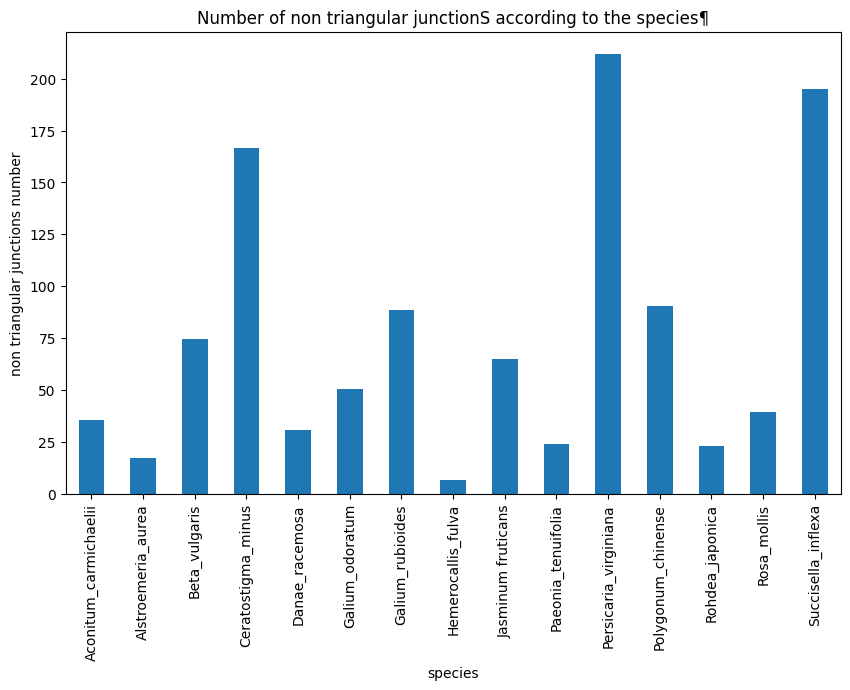

In [34]:
# We compute the bar plot
df_nb_non_triangular_junction_species.plot(kind='bar', 
                                           title='Number of non triangular junctionS according to the species¶',
                                           ylabel='non triangular junctions number', 
                                           xlabel='species', 
                                           figsize=(10, 6))
# We save it

plt.savefig(data_folder_path + "/results/" +'figure_bar_plot_connected_cells.png')